<a href="https://colab.research.google.com/github/ckj18/ML.github.io/blob/main/DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# YOLOv5 종속 항목 설치
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import cv2
import albumentations as alb
import matplotlib.pyplot as plt
import torch

from albumentations.pytorch import ToTensorV2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd DA-sample

/content/drive/MyDrive/DA-sample


In [ ]:
ls

background1.jpg  frame0.jpg   frame1.jpg   output_image.png  sample3.jpg
city_image.png   frame14.jpg  frame34.jpg  sample1.jpg       sample4.jpg
city_mask.png    frame17.jpg  output/      sample2.jpg


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-7-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-rs_w84ia
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug /tmp/pip-req-build-rs_w84ia
  Resolved https://github.com/aleju/imgaug to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


In [ ]:
%matplotlib inline

In [ ]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow

class Img_aug:
    def __init__(self):
        self.sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                iaa.Fliplr(0.25),
                self.sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                )),
                self.sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # x축과 y축의 크기 조절 범위
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x축과 y축으로의 이동 범위
                    rotate=(-20, 20),  # 회전 각도 범위
                    shear=(-12, 12),  # 기울기 범위
                    order=[0, 1],  # 보간법 선택 (0: 최근접 이웃, 1: 쌍선형 보간)
                    cval=(0, 255),  # 상수 채우기 모드인 경우 사용할 상수 범위
                    mode=ia.ALL  # 변형에 사용할 모드 선택
                )),
                iaa.SomeOf((0, 5),
                           [
                               self.sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),  # 슈퍼픽셀 변환
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # 가우시안 블러
                                   iaa.AverageBlur(k=(2, 7)),  # 평균 블러
                                   iaa.MedianBlur(k=(3, 11)),  # 중간값 블러
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # 선명도 조절
                               iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # 엠보싱
                               iaa.SimplexNoiseAlpha(iaa.OneOf([
                                   iaa.EdgeDetect(alpha=(0.5, 1.0)),
                                   iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                               ])),
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02 * 255), per_channel=0.5),  # 가우시안 노이즈
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.05), per_channel=0.20),  # 확률적으로 픽셀 제거
                                   iaa.CoarseDropout((0.01, 0.05), size_percent=(0.01, 0.02), per_channel=0.2),
                               ]),
                               iaa.Invert(0.05, per_channel=True),  # 색상 반전
                               iaa.Add((-10, 10), per_channel=0.5),  # 밝기 조절
                               iaa.AddToHueAndSaturation((-20, 20)),  # 색조와 채도 조절
                               iaa.OneOf([
                                   iaa.Multiply((0.5, 1.5), per_channel=0.5),  # 색상 증폭
                                   iaa.FrequencyNoiseAlpha(
                                       exponent=(-4, 0),
                                       first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                       second=iaa.ContrastNormalization((0.4, 2.0))
                                   )
                               ]),
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.2),  # 대비 조절
                               iaa.Grayscale(alpha=(0.0, 1.0)),  # 흑백 변환
                               self.sometimes(iaa.ElasticTransformation(alpha=(0.3, 2.5), sigma=0.25)),  # 탄성 변형
                               self.sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.02))),  # 조각 모양 왜곡
                               self.sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.02)))  # 원근 변형
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn

/content/drive/MyDrive/DA-sample


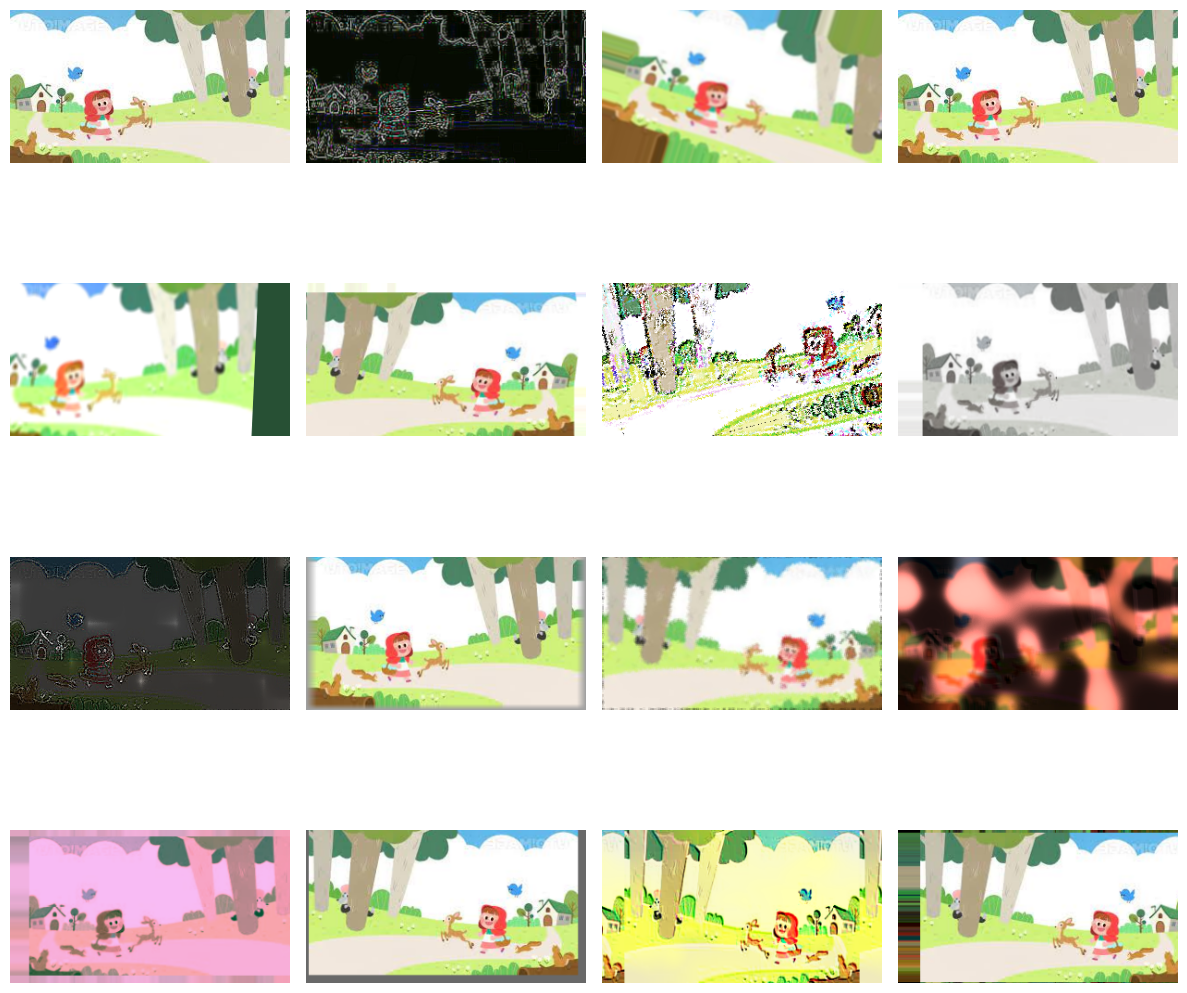

Complete augmenting images


In [ ]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

aug = Img_aug()
augment_num = 16  # 출력되는 이미지의 개수를 16개로 고정

name = 'red'

currentPath = os.getcwd()
print(currentPath)
os.chdir(currentPath)

save_path = 'sample/' + name
os.makedirs(save_path, exist_ok=True)

img = cv2.imread('sample1.jpg')

fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 subplot을 생성

for i in range(augment_num):
    row = i // 4  # 이미지의 행 인덱스
    col = i % 4  # 이미지의 열 인덱스

    augmented_img = aug.seq.augment_image(img)
    axs[row, col].imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

    cv2.imwrite(save_path + '/' + name + '_{}.jpg'.format(i), augmented_img)

plt.tight_layout()  # subplot 간격 조정
plt.show()

print('Complete augmenting images')


/content/drive/MyDrive/DA-sample


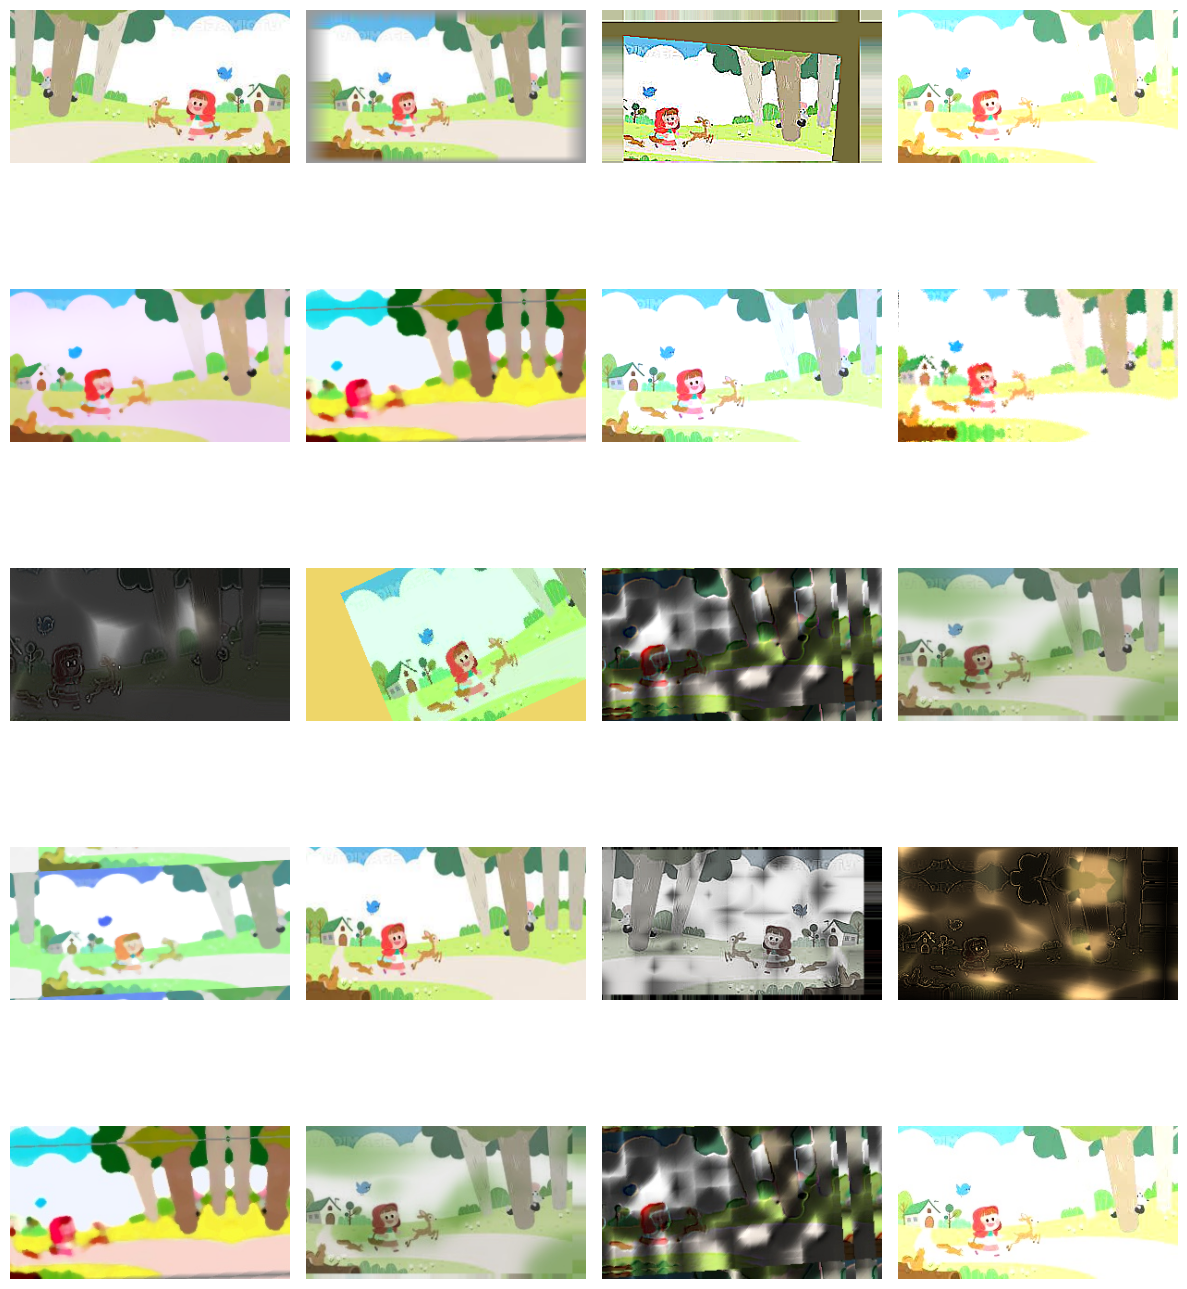

Complete augmenting images


In [ ]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random

aug = Img_aug()
augment_num = 16

name = 'red'

currentPath = os.getcwd()
print(currentPath)
os.chdir(currentPath)

save_path = 'output/' + name
os.makedirs(save_path, exist_ok=True)

img = cv2.imread('sample1.jpg')

fig, axs = plt.subplots(5, 4, figsize=(12, 15))  # 5x4 subplot을 생성 (기존 4x4에 추가로 한 행 추가)

# 생성된 이미지 출력
for i in range(augment_num):
    row = i // 4  # 이미지의 행 인덱스
    col = i % 4  # 이미지의 열 인덱스

    augmented_img = aug.seq.augment_image(img)
    axs[row, col].imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

    cv2.imwrite(save_path + '/' + name + '_{}.jpg'.format(i), augmented_img)

# 랜덤하게 선택된 이미지 합성 및 출력
for i in range(4):
    row = 4  # 이미지의 행 인덱스 (추가된 행)
    col = i  # 이미지의 열 인덱스

    # 랜덤하게 이미지 선택
    random_index = random.randint(0, augment_num - 1)
    augmented_img = cv2.imread(save_path + '/' + name + '_{}.jpg'.format(random_index))

    axs[row, col].imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

    # 이미지 합성 처리
    # 여기에 이미지 합성 처리를 추가하세요

plt.tight_layout()
plt.show()

print('Complete augmenting images')


In [ ]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import random

aug = Img_aug()
augment_num = 16

name = 'image'

img = cv2.imread('sample1.jpg')

currentPath = '/content/drive/MyDrive/'
print(currentPath)
os.chdir(currentPath)

save_path = 'sample/' + name
os.makedirs(save_path, exist_ok=True)

# 생성된 이미지 출력 및 저장
generated_images = []
for i in range(augment_num):
    augmented_img = aug.seq.augment_image(img)
    generated_images.append(augmented_img)

    cv2.imwrite(save_path + '/' + name + '_{}.jpg'.format(i), augmented_img)

# Mix 처리
for i in range(4):
    row = 4  # 이미지의 행 인덱스 (추가된 행)
    col = i  # 이미지의 열 인덱스

    # 랜덤하게 이미지 선택
    random_indices = random.sample(range(augment_num), 2)
    img1 = generated_images[random_indices[0]]
    img2 = generated_images[random_indices[1]]

    # Mix 처리
    mixed_img = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
    cv2.imwrite(save_path + '/mixed_{}.jpg'.format(i), mixed_img)

/content/drive/MyDrive/


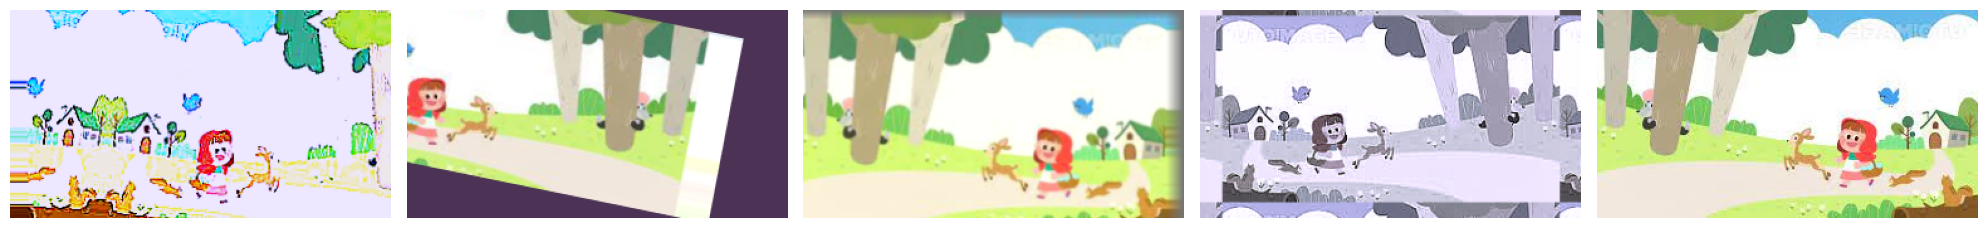

Complete augmenting images


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# 유사도 계산 및 유사도가 덜 높은 이미지 출력
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
similarities = []

for i, generated_img in enumerate(generated_images):
    generated_gray = cv2.cvtColor(generated_img, cv2.COLOR_BGR2GRAY)
    similarity = ssim(original_img, generated_gray)
    similarities.append(similarity)

# 유사도가 덜 높은 이미지의 인덱스를 가져옴
similar_indices = np.argsort(similarities)[::-1][7:12]

# 유사도가 덜 높은 이미지 출력
for i, idx in enumerate(similar_indices):
    axs[i].imshow(cv2.cvtColor(generated_images[idx], cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print('Complete augmenting images')